# **ENGG680 - Introduction to Digital Engineering**
## *Lab Assignment 3: Introduction to Machine Learning (Gradient Descent, Logistic Regression)*

## Preliminary: Certificate of Work


*We, the undersigned, certify that this is our own work, which has been done expressly for this course, either without the assistance of any other party or where appropriate we have acknowledged the work of others. Further, we have read and understood the section in the university calendar on plagiarism/cheating/other academic misconduct and we are aware of the implications thereof. We request that the total mark for this assignment be distributed as follows among group members:*

|          | First Name | Last Name | Signature (Full Name, Date) | Hours | Contribution % |
|----------|------------|-----------|-----------------------------|-------|----------------|
| Member 1: | Amanda | Choy | Amanda Choy, 6/10/2024 | 5 | 25% |
| Member 2: | Di | Su | Di Su, 6/10/2024 | 5 | 25% |
| Member 3: | Jeelkumar  | Patel | Jeelkumar Patel, 6/10/2024 | 5 | 25% |
| Member 4: | Nathaniel | Lamptey | Nathaniel Lemptey, 6/10/2024 | 5 | 25% |


# **Non-linear Gradient Descent (25 marks)**

### **Observations:** Pseudorange [m]

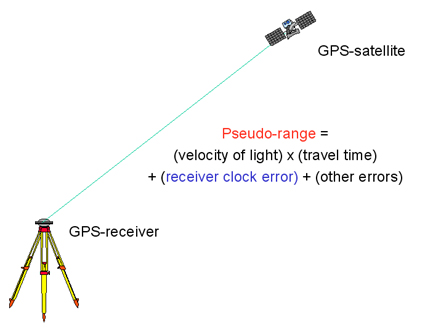

<font size="1.5">Image source: *ICA Course on Toponymy. https://unstats.un.org/unsd/geoinfo/ungegn/docs/_data_icacourses/_HtmlModules/_Selfstudy/S06/S06_05b.html.*</font>

**Pseudorange** is the *pseudo* distance between a satellite and a satellite signal receiver on the ground. In simple words, it contains the geometric range between the satellite and the receiver, with additional associated errors.

The simplified version of the Pseudorange measurement model is:
$$P=\rho-cdT+ϵ_{sum}$$ and
$$\rho=\sqrt{(x_s - x_r)^2 + (y_s - y_r)^2 + (z_s - z_r)^2}$$
where
$$\rho=geometric\ range$$
$${x_s, y_s, z_s, x_r,y_r,z_r} = 3D\ coordinates\ of\ satellite\ and\ receiver$$
$$cdT = receiver\ clock\ offset$$
$$ϵ_{sum}=general\ errors\ term\ (ϵ_{sum}=\Delta \rho + \Delta_{\text{ion}} + \Delta_{\text{trop}} + \epsilon_P + cdt)$$

\\
Note: the 3D **positions of satellites** are given in this assignment.

### **Unknown States:** Position of receiver & receiver clock offset

We use the psuedorange measurements to estimate the receiver's **3-dimensional position** and the **receiver clock offset:** $$X={x_r,y_r,z_r,cdT}$$.

These will be our states of interest, and we are going to estimate them using Gradient Descent method


.

###Step 0: Setup & Intialization

Step 0.1: Import necessary libraries

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Step 0.2: Read and parse data files

In [32]:
from google.colab import drive
drive.mount('/content/drive')

df_pseudorange = pd.read_excel('https://raw.github.com//jeelp97//ENGG-680-lab//main//pseudoranges1.xlsx')
df_sat_pos = pd.read_excel('https://raw.github.com//jeelp97//ENGG-680-lab//main//satellite_position1.xlsx')

pseudorange = df_pseudorange['P'].to_numpy()
sat_pos =df_sat_pos[['x','y','z']].to_numpy()

n = pseudorange.size

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Step 0.3: Define the groundtruth of receiver's position in ECEF (m)

In [24]:
GroundTruth=np.array([-1633489.37967725,	-3651627.18250363,	4952481.61954918])

Step 0.4: Intialize empty arrays

In [33]:
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

Step 0.5: Function that
computes the euclidean distance between satellite and receiver

In [34]:
def euclidean_norm(receiver_pos, satellite_pos):

    # Calculate the Euclidean norm (distance)
    distance = np.linalg.norm(satellite_pos - receiver_pos, axis =1)

    return distance


### Step 1: Define the Cost Function (4 marks)
Define a cost function that computes the sum of squared residuals between measured and predicted pseudoranges.

The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.

The function returns a single scalar.

Call euclidean_norm function to calculate geometric distance.

In [35]:
# Cost function: computes the average of the sum of squared residuals between measured and predicted pseudoranges
def cost_function(r_pos, cdT, s_pos, pseudorange):

    # Step 1: Determine the number of pseudoranges provided
    # n is the total number of observed pseudorange values in the input array pseudorange
    # We use n to calculate the mean squared residuals later
    n = pseudorange.size

    # Step 2: Calculate the predicted pseudoranges for each satellite
    # We use euclidean_norm to calculate the geometric distances from the receiver to each satellite
    # and add the receiver clock offset cdT to get the predicted pseudoranges.
    # predicted_pseudoranges will be an array of predicted values for each satellite
    predicted_pseudoranges = euclidean_norm(r_pos, s_pos) + cdT

    # Step 3: Calculate the residuals
    # The residuals are the differences between the observed pseudoranges and the predicted pseudoranges
    # A positive residual means the prediction was less than the observed value, and vice versa
    residuals = pseudorange - predicted_pseudoranges

    # Step 4: Calculate the sum of squared residuals and average it
    # Squaring each residual ensures that all differences are positive and amplifies larger errors
    # Taking the mean (dividing by n) gives the average squared residual
    L = (1/n) * (np.sum(residuals ** 2))

    # Step 5: Return the final cost value
    # The cost L represents the average error between observed and predicted pseudoranges
    return L

### Step 2: Define the Gradient Computation Function (4 marks)

Define a gradient computation function that calculates the gradient of the cost function with respect to the estimates (x_r, y_r, z_r, cdT).


The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.


The function returns a 1D numpy array that contains 4 elements.


Call euclidean_norm function to calculate geometric distance.


In [36]:
# Gradient of the cost function with respect to the unknowns (x_r, y_r, z_r, cdT)
def gradient(r_pos, cdT, s_pos, pseudorange):

    # Step 1: Determine the number of pseudorange observations
    # n is the number of observed pseudorange values, used for averaging the gradients later
    n = pseudorange.size

    # Step 2: Calculate the predicted pseudoranges
    # This line computes the predicted pseudoranges by calculating the geometric distance between
    # the receiver position r_pos and each satellite position in s_pos and adding the clock offset cdT.
    predicted_pseudoranges = euclidean_norm(r_pos, s_pos) + cdT

    # Step 3: Calculate the residuals (differences between observed and predicted pseudoranges)
    # Residuals represent the error between each observed pseudorange and the predicted pseudorange
    # They show how far off the predictions are for each satellite
    residuals = pseudorange - predicted_pseudoranges

    # Step 4: Initialize the gradient vector with zeros
    # grad is a 1D array with four elements to store the partial derivatives of the cost function
    # with respect to x_r, y_r, z_r, and cdT
    grad = np.zeros(4)

    # Step 5: Compute the gradients for x_r, y_r, and z_r
    # The partial derivative of the cost function with respect to each position coordinate
    # (x_r, y_r, z_r) includes the residuals scaled by the component-wise difference
    # between the receiver and satellite positions
    x = residuals * ((r_pos[0] - s_pos[:, 0]) / predicted_pseudoranges)
    y = residuals * ((r_pos[1] - s_pos[:, 1]) / predicted_pseudoranges)
    z = residuals * ((r_pos[2] - s_pos[:, 2]) / predicted_pseudoranges)

    # Step 6: Compute the final values of each gradient component
    # Multiply by (-2/n) to scale the gradient by the number of observations (average gradient)
    # Each component of grad corresponds to the direction and magnitude for updating x_r, y_r, z_r, and cdT
    grad[0] = (-2 / n) * (np.sum(x))  # Gradient with respect to x_r
    grad[1] = (-2 / n) * (np.sum(y))  # Gradient with respect to y_r
    grad[2] = (-2 / n) * (np.sum(z))  # Gradient with respect to z_r
    grad[3] = (-2 / n) * (np.sum(residuals))  # Gradient with respect to cdT (clock offset)

    # Step 7: Return the gradient vector
    # grad is now an array with four values that show the partial derivatives
    # of the cost function with respect to x_r, y_r, z_r, and cdT
    return grad

### Step 3: Gradient Descent Implementation (4 marks)
Construct the implementation function of gradient descent

Replace '...' with actual implementation

The function's input are: observed pseudoranges, satellites' positions, learning_rate, maximum loop iterations, tolerance

The function will return a 1D numpy array that contains the optimized estimates (x_r, y_r, z_r, cdT)

The function set learning_rate, max_iters and tolerance as: 0.01, 100000, 1e-6 as default values

These default hyperparameters values can be overridden by passing your own values when calling the function


In [37]:
# Gradient descent algorithm for non-linear least squares estimation
def gradient_descent(pseudorange, s_pos, learning_rate=0.1, max_iters=10000, tolerance=1e-6):

    global steps_count  # Use a global variable to track the number of steps it took to converge

    # Step 1: Initialize the estimates for receiver's position and clock offset to zero
    # X is a 1D array where the first three elements represent the receiver's position [x_r, y_r, z_r]
    # and the fourth element represents the clock offset cdT.
    X = np.array([0.0, 0.0, 0.0, 0.0])  # Initial guess at [x_r, y_r, z_r, cdT]

    # Lists to track the progress of cost, gradients, and position error at each step
    global arr_cost, arr_grad, arr_err  # Track these variables for analysis after convergence
    arr_cost = []  # To store the cost at each iteration
    arr_grad = []  # To store gradients at each iteration
    arr_err = []   # To store positional error (difference from GroundTruth)

    # Step 2: Begin gradient descent loop for a maximum of max_iters iterations
    for iteration in range(max_iters):

        # Extract receiver position and clock offset from the estimates
        # r_pos stores [x_r, y_r, z_r] and cdT stores the clock offset
        r_pos = X[:3]
        cdT = X[3]

        # Step 3: Calculate the current cost (sum of squared residuals) at the current estimates
        # We call cost_function with r_pos, cdT, s_pos, and pseudorange to get the current cost value
        current_cost = cost_function(r_pos, cdT, s_pos, pseudorange)

        # Step 4: Compute the gradient (partial derivatives) of the cost function at the current estimates
        # We call gradient with r_pos, cdT, s_pos, and pseudorange to get the gradient values
        grad = gradient(r_pos, cdT, s_pos, pseudorange)

        # Step 5: Update the estimates by taking a step in the opposite direction of the gradient
        # X_new is calculated by subtracting (learning_rate * grad) from X to move towards the minimum
        X_new = X - (learning_rate * grad)

        # Step 6: Calculate the new cost after the update
        # We calculate new_cost by passing the updated estimates X_new to cost_function
        new_cost = cost_function(X_new[:3], X_new[3], s_pos, pseudorange)

        # Step 7: Check for convergence
        # If the difference between the new cost and current cost is less than tolerance, we stop the loop
        if np.abs(new_cost - current_cost) < tolerance:
            print("Converged!")
            steps_count = iteration  # Record the number of iterations taken to converge
            break  # Exit the loop since we've converged

        # Step 8: Update the estimates for the next iteration
        # We set X to X_new so that the next iteration uses the updated values
        X = X_new

        # Step 9: Track intermediate results for analysis
        # We add the current cost, gradient, and error (difference from GroundTruth) to their respective lists
        arr_cost.append(current_cost)  # Track the cost at this step
        arr_grad.append(grad)          # Track the gradient at this step
        arr_err.append(X[:3] - GroundTruth)  # Track the position error from GroundTruth (replace with actual known values)

    # Step 10: Return the final optimized estimates for x_r, y_r, z_r, and cdT
    return X

### Step 4: Parameters Optimization & Results Printing (3 marks)

Call *gradient_descent* function to optimize the estimating parameters using default optimization hyperparameters

Print:

*   optimized parameters
*   final position errors of receiver
*   number of steps taken for convergence
*   final cost value
*   final gradient values








In [38]:
# Step 1: Call the gradient_descent function with specified parameters
# This function will optimize the receiver's position and clock offset using the provided learning rate, maximum iterations, and tolerance
optimized_params = gradient_descent(pseudorange, sat_pos, learning_rate=0.1, max_iters=10000, tolerance=1e-6)

# Step 2: Print the optimized parameters
# optimized_params now contains the final estimated values for the receiver's position (x_r, y_r, z_r) and clock offset (cdT)
print("Optimized Parameters (x_r, y_r, z_r, cdT):", optimized_params)

# Step 3: Print the final position error of the receiver
# arr_err is a list that stores the position error at each iteration.
# arr_err[-1] gives the error at the last iteration, showing how close the estimated position is to the actual position.
print("Final Position Error of the Receiver:", arr_err[-1])

# Step 4: Print the number of steps taken for convergence
# steps_count is a variable that tracks the number of iterations it took for the algorithm to converge.
print("Number of Steps Taken for Convergence:", steps_count)

# Step 5: Print the final cost value
# arr_cost is a list that stores the cost at each iteration.
# arr_cost[-1] provides the final cost after optimization, representing the remaining error in terms of sum of squared residuals.
print("Final Cost Value:", arr_cost[-1])

# Step 6: Print the final gradient values
# arr_grad is a list that stores the gradient values at each iteration.
# arr_grad[-1] gives the gradient at the last step, showing how much further adjustments could be made (ideally close to zero if converged).
print("Final Gradient Values:", arr_grad[-1])

Converged!
Optimized Parameters (x_r, y_r, z_r, cdT): [-1.63349244e+06 -3.65162953e+06  4.95248539e+06  6.44842179e+00]
Final Position Error of the Receiver: [-3.06240961 -2.34633587  3.7715453 ]
Number of Steps Taken for Convergence: 2944
Final Cost Value: 0.5634452430848553
Final Gradient Values: [ 0.00015517  0.0008646  -0.00265729 -0.00150649]


### Step 5: Cost vs Steps Plot & Analysis (2 marks)
Plot cost vs steps

Use 'semilogy' to scale y-axis

Label each axis

Include figure title

Comment on the pattern from the plot

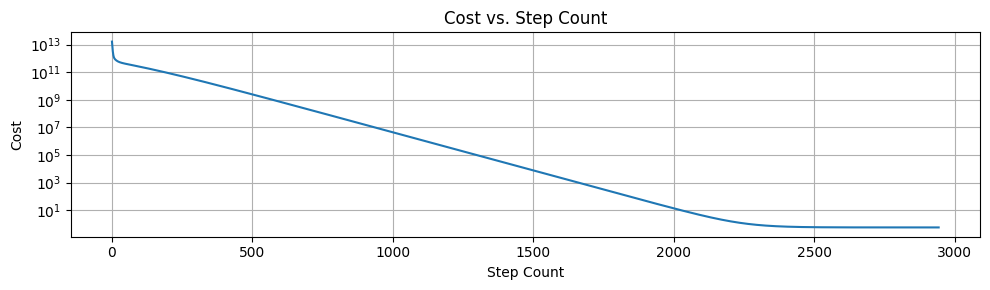

In [39]:
# Step 1: Set up a single subplot for the cost function plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))

# Step 2: Create an array representing the number of steps taken
# steps_count_x is an array with values from 0 up to the total number of cost entries in arr_cost
# This represents the x-axis, showing the step count as iterations progress
steps_count_x = np.arange(len(arr_cost))

# Step 3: Plot the cost function using a logarithmic scale for the y-axis
# plt.semilogy creates a line plot with a logarithmic scale on the y-axis, which is useful for visualizing how
# the cost decreases exponentially (if applicable) as steps increase.
plt.semilogy(steps_count_x, arr_cost)

# Step 4: Enable grid for the plot for better readability
ax.grid(True)  # Adds grid lines to the plot to make it easier to see the trend

# Step 5: Label the x-axis, y-axis, and title
plt.xlabel('Step Count')  # Label for the x-axis showing the number of iterations
plt.ylabel('Cost')  # Label for the y-axis representing the cost value
plt.title('Cost vs. Step Count')  # Title of the plot, describing what it shows

# Step 6: Adjust layout and display the plot
# fig.tight_layout() automatically adjusts subplot parameters to fit everything within the plot neatly
fig.tight_layout()
plt.show()  # Display the plot

### Step 6: Gradients vs Steps & Analysis(2 marks)
Plot gradients vs steps

use 'symlog' to scale y-axis

use 'tick_params' and set y-axis: labelsize=8

include axes' labels, legends and title

Comment on the pattern from the plot

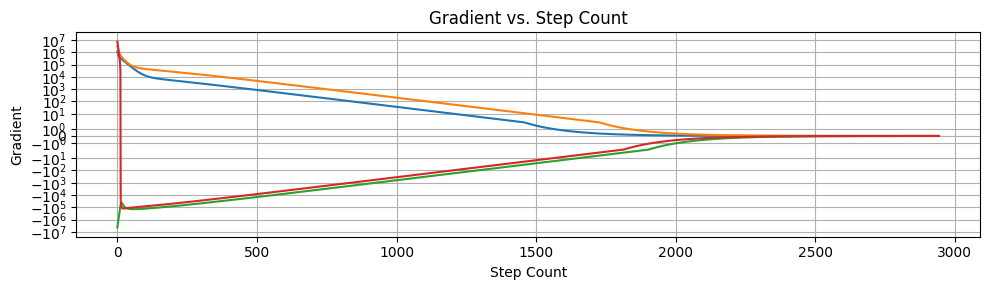

In [40]:
# Step 1: Set up a single subplot for the gradient plot
# fig, ax defines a figure fig and an axis ax for plotting
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))  # 1 row, 1 column plot with specified size

# Step 2: Create an array for the step count
# steps_count_x represents the step count for each recorded gradient,
# with len(arr_grad) being the total number of steps in the array arr_grad
steps_count_x = np.arange(len(arr_grad))

# Step 3: Plot the gradient values against the step count
# plt.plot generates a line plot showing the gradient values recorded in arr_grad
plt.plot(steps_count_x, arr_grad)

# Step 4: Set the y-axis to use a symmetrical logarithmic scale
# plt.yscale('symlog') applies a symmetrical logarithmic scale to the y-axis,
# useful for showing both small and large gradient magnitudes on a balanced scale
plt.yscale('symlog')

# Step 5: Enable grid lines for readability
ax.grid(True)  # Adds grid lines to help interpret values

# Step 6: Label the x-axis, y-axis, and title the plot
plt.xlabel('Step Count')  # Label for x-axis representing the number of gradient descent steps
plt.ylabel('Gradient')  # Label for y-axis representing the gradient magnitude
plt.title('Gradient vs. Step Count')  # Title describing the plot content

# Step 7: Adjust layout and display the plot
# fig.tight_layout() ensures the plot components fit well within the figure
fig.tight_layout()
plt.show()  # Displays the plot

### Step 7: Positioning errors vs Steps & Analysis(2 marks)
Plot positioning errors vs steps

Include axes' labels, legends and title

Comment on the pattern of the plot

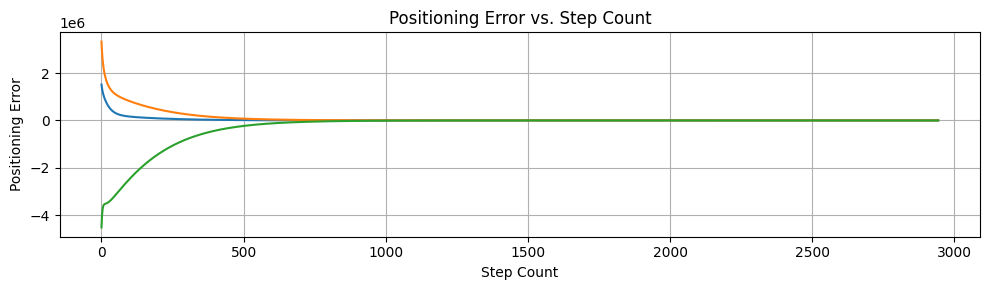

In [42]:
# Step 1: Set up a single subplot for the positioning error plot
# fig, ax defines a figure fig and an axis ax for plotting
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))  # Creates a 1x1 plot with specified size

# Step 2: Create an array for step count
# steps_count_x holds an array of step numbers for each recorded positioning error in arr_err
# np.arange(len(arr_err)) generates a range from 0 to the total number of entries in arr_err
steps_count_x = np.arange(len(arr_err))

# Step 3: Plot the positioning error values against the step count
# plt.plot generates a line plot showing the recorded positioning error in arr_err over steps
plt.plot(steps_count_x, arr_err)

# Step 4: Enable grid for readability
# ax.grid(True) adds grid lines to help read values accurately on the plot
ax.grid(True)

# Step 5: Label the x-axis, y-axis, and title of the plot
plt.xlabel('Step Count')  # Label for the x-axis showing the number of iterations
plt.ylabel('Positioning Error')  # Label for the y-axis representing error in position estimation
plt.title('Positioning Error vs. Step Count')  # Title describing the plot content

# Step 6: Adjust layout and display the plot
# fig.tight_layout() adjusts subplot parameters to fit the plot neatly within the figure
fig.tight_layout()
plt.show()  # Displays the plot

# Hyperparameters Tuning

### Step 8: Tuning Learning rate (2 marks)

Change learning rate to 0.01, 0.001 and repeat step 4.

(*hint: you may need to adjust the maximum loop iterations in this case*)

In [46]:
# Step 1: Set the learning rate to a lower value of 0.01
# This makes the gradient descent updates smaller, potentially leading to a more accurate convergence
learning_rate = 0.01

# Step 2: Re-initialize arrays and counters to store results from a fresh run
# arr_cost, arr_grad, and arr_err are reset to empty lists to track costs, gradients, and errors respectively in this new run
# steps_count is reset to 0 to count iterations for this new gradient descent run
arr_cost = []  # Stores cost at each step
arr_grad = []  # Stores gradient at each step
arr_err = []   # Stores positioning error at each step
steps_count = 0  # Resets step count for tracking convergence

# Step 3: Run gradient descent with the updated learning rate
# Calling gradient_descent again with the lower learning_rate and extended max_iters
# optimized_params_2 will store the final estimated values [x_r, y_r, z_r, cdT] after this run
optimized_params_2 = gradient_descent(pseudorange, sat_pos, learning_rate=0.01, max_iters=100000, tolerance=1e-6)

# Step 4: Print the final metrics
# Print optimized_params_2 which contains the final optimized position and clock offset estimates
print("Optimized Parameters (x_r, y_r, z_r, cdT):", optimized_params_2)

# Print the final positioning error
# arr_err[-1] provides the final positioning error recorded in this run, showing how close the estimate is to the true position
print("Final Position Error of the Receiver:", arr_err[-1])

# Print the number of steps taken to converge
# steps_count tracks the number of iterations to reach the tolerance or maximum iterations
print("Number of Steps Taken for Convergence:", steps_count)

# Print the final cost value
# arr_cost[-1] represents the final cost, showing the remaining error after optimization
print("Final Cost Value:", arr_cost[-1])

# Print the final gradient values
# arr_grad[-1] gives the final gradient values for each parameter, ideally close to zero if convergence is achieved
print("Final Gradient Values:", arr_grad[-1])

Converged!
Optimized Parameters (x_r, y_r, z_r, cdT): [-1.63349244e+06 -3.65162950e+06  4.95248530e+06  6.39730478e+00]
Final Position Error of the Receiver: [-3.05714451 -2.3169989   3.6813805 ]
Number of Steps Taken for Convergence: 27703
Final Cost Value: 0.5641548423540386
Final Gradient Values: [ 0.00048857  0.00272229 -0.00836675 -0.00474335]


## Step 9: Results Analysis (2 marks)

Q1. Comment on the difference that you notice after changing the learning rate. (1 mark)

Q2. What is the difference between LSE and Gradient Descent? (Comment based on your results and the methodology) (1 mark)



A1.(needs to rephrase)
Step 4 Compared with when the learning rate is 0.01，lower learning rates improve accuracy and stability but require more steps, while higher rates speed up convergence at the risk of slightly higher final errors or instability.
However, when learning rate of 0.001 is too low to drive the algorithm effectively toward the minimum, resulting in high error and poor convergence.

A2.

# **Logistic Regression (50 marks)**

The following dataset helps to predict phishing webpages. It is collected mainly from: PhishTank archive, MillerSmiles archive, Googleâ€™s searching operators.

It can be downloaded from : https://archive.ics.uci.edu/dataset/327/phishing+websites

<u>Class labels:</u>

Not phishing = -1

Phishing = 1



Follow the steps provided to perform binary classification using logistic regression and complete the code for each part.


### Step 0: Import Libraries

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Step 1: Data Input (2 mark)

Use the `fetch_ucirepo(id=<ID>)`  to load the phishing dataset (id = 327) as a dataframe into the feature matrix `X` and target vector `y`.

Print the size of `X` and `y`


In [48]:
!pip install ucimlrepo

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo

# Below code fetches dataset
phishing_websites = fetch_ucirepo(id=327)

# TO DO: data (as pandas dataframes) (1 mark)
# Access feature_names directly as an attribute
data = phishing_websites.data.features
feature_names = phishing_websites.feature_names

# Create the DataFrame
df = pd.DataFrame(data, columns=feature_names)
X = df  # Feature matrix


# Assuming the target is a single column DataFrame or Series, access it by index
y = pd.Series(phishing_websites.data.targets.iloc[:, 0], name="target") # Accessing the first (and likely only) column


# TO DO: display sizes of X and y (1 mark)
print("Size of X (features):", X.shape)
print("Size of y (target):", y.shape)



Size of X (features): (11055, 30)
Size of y (target): (11055,)


### Step 2.1: Class label histogram (2 marks)

Plot the histogram for each class label to visualise class imbalance. Additionally before calling .show() for the plot, ensure that the code displays you the exact value of the samples for each class above the respective bins.

Class distribution:
 {-1: 4898, 1: 6157}


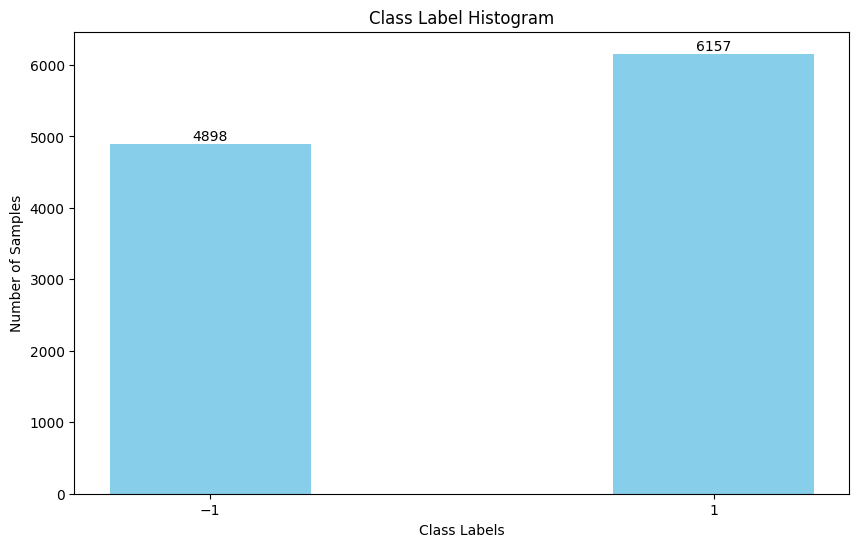

In [50]:
# TO DO: Check the class distribution of y (2 mark)
# Check if y is empty and handle it appropriately
if y.empty:
    print("Target variable 'y' is empty. Cannot generate class distribution.")
else:
    class_labels, counts = np.unique(y, return_counts=True)
    print("Class distribution:\n", dict(zip(class_labels, counts)))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    bars = plt.bar(class_labels, counts, color='skyblue')

    # Adding exact values above the bins
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval, int(yval),
                 ha='center', va='bottom')  # va: vertical alignment

    # Setting title and labels
    plt.title('Class Label Histogram')
    plt.xlabel('Class Labels')
    plt.ylabel('Number of Samples')

    # Ensure class_labels is a valid type for xticks.
    # If not numeric, cast it to a suitable type.
    if not np.issubdtype(class_labels.dtype, np.number):
        # Attempting conversion to numeric; Adjust the type if necessary
        class_labels = class_labels.astype(int)

    plt.xticks(class_labels) # Ensuring all class labels are shown


# Display exact values for each bin in the histogram

plt.show()



### Step 2.2: Smaller dataset creation(2 mark)


We also want to test if the model would still work if we used less data. Use the `train_test_split` function from sklearn to create a new feature matrix named `X_small` and a new target vector named `y_small` that contain **3%** of the data.

Use random_state = 42


In [51]:
# TO DO: Create a smaller dataset with 3% of the data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split

# Fetch the dataset
phishing_websites = fetch_ucirepo(id=327)

# Access features directly as an attribute
data = phishing_websites.data.features
feature_names = phishing_websites.feature_names

# Create the DataFrame for features
df = pd.DataFrame(data, columns=feature_names)
X = df  # Feature matrix
y = pd.Series(phishing_websites.data.targets.iloc[:, 0], name="target")  # Target vector

# TO DO: Create a smaller dataset with 3% of the data
X_small, _, y_small, _ = train_test_split(X, y, test_size=0.97, random_state=42)

# TO DO: display sizes of X_small and y_small (2 mark)
print("Size of X_small (3% of features):", X_small.shape)
print("Size of y_small (3% of target):", y_small.shape)

Size of X_small (3% of features): (331, 30)
Size of y_small (3% of target): (331,)


### Step 3: Implement Machine Learning Model (6 marks)

1. Import `LogisticRegression` from sklearn
2. Instantiate model `LogisticRegression(max_iter=2000)`
3. Implement the machine learning model with three different datasets:
    - `X` and `y` (1 mark)
    - Only first two columns of `X` and `y` (1 mark)
    - `X_small` and `y_small` (1 mark)

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression # Import LogisticRegression

# Instantiate Logistic Regression model with max_iter=2000
model = LogisticRegression(max_iter=2000)
# Implement the model on the full dataset (X and y)
model.fit(X, y)
print("Model trained on the full dataset (X and y)")

# Implement the model on the dataset with only the first two columns of X and y
model.fit(X.iloc[:, :2], y)
print("Model trained on the first two columns of X and y")

# Implement the model on the smaller dataset (X_small and y_small)
model.fit(X_small, y_small)
print("Model trained on the smaller dataset - 3% of data (X_small and y_small)")

Model trained on the full dataset (X and y)
Model trained on the first two columns of X and y
Model trained on the smaller dataset - 3% of data (X_small and y_small)


### Step 4: Test Model (6 x 3 = 18 marks)

Calculate the following for the **three different tests** implemented in Step 3
1. data size (1 mark)
1. number of training samples (1 mark)
2. number of testing samples (1 mark)
4. training accuracy (1 marks)
5. testing accuracy (1 marks)
6. log loss (1 mark)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss

# Fetch the dataset
phishing_websites = fetch_ucirepo(id=327)
data = phishing_websites.data.features
feature_names = phishing_websites.feature_names
df = pd.DataFrame(data, columns=feature_names)
X = df  # Feature matrix
y = pd.Series(phishing_websites.data.targets.iloc[:, 0], name="target")  # Target vector

# Create a smaller dataset with 3% of the data
X_small, _, y_small, _ = train_test_split(X, y, test_size=0.97, random_state=42)

# Instantiate Logistic Regression model with max_iter=2000
model = LogisticRegression(max_iter=2000)


# Define datasets to loop through for training and testing
datasets = [
    ("Full Dataset", X, y),
    ("First Two Columns", X.iloc[:, :2], y),
    ("Smaller Dataset", X_small, y_small)
]

# Loop through datasets and calculate required metrics
for name, X_data, y_data in datasets:
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=42)

    # Fit the model on the training set
    model.fit(X_train, y_train)

    # Calculate training and testing accuracy
    train_accuracy = accuracy_score(y_train, model.predict(X_train))
    test_accuracy = accuracy_score(y_test, model.predict(X_test))

    # Calculate log loss on the test set
    y_pred_proba = model.predict_proba(X_test)
    test_log_loss = log_loss(y_test, y_pred_proba)

    # Display results
    print(f"Results for {name}:")
    print(f"  Data Size: {X_data.shape}")
    print(f"  Number of Training Samples: {X_train.shape[0]}")
    print(f"  Number of Testing Samples: {X_test.shape[0]}")
    print(f"  Training Accuracy: {train_accuracy:.4f}")
    print(f"  Testing Accuracy: {test_accuracy:.4f}")
    print(f"  Log Loss: {test_log_loss:.4f}\n")


Results for Full Dataset:
  Data Size: (11055, 30)
  Number of Training Samples: 7738
  Number of Testing Samples: 3317
  Training Accuracy: 0.9311
  Testing Accuracy: 0.9219
  Log Loss: 0.1879

Results for First Two Columns:
  Data Size: (11055, 2)
  Number of Training Samples: 7738
  Number of Testing Samples: 3317
  Training Accuracy: 0.5540
  Testing Accuracy: 0.5773
  Log Loss: 0.6774

Results for Smaller Dataset:
  Data Size: (331, 30)
  Number of Training Samples: 231
  Number of Testing Samples: 100
  Training Accuracy: 0.9481
  Testing Accuracy: 0.9300
  Log Loss: 0.1923



### Step 5.1: Visualize Results (3 marks)

1. Create a pandas DataFrame `results` with columns: Data size, training samples, testing samples, training accuracy, testing accuracy, log loss
2. Add these columns for each dataset to the `results` DataFrame
3. Print `results`

For any **random state** parameters from this step onwards, you can use random_state = 0;

In [ ]:
#TO DO: Complete steps 3,4, and 5.1 in this code block (Total 27 marks)

# Note: 70% training set, 30% testing set
# HINT: create a function that calculates all required information


# Function to calculate required information
def calculate_metrics(X_data, y_data):
    # Split data into training and testing sets (70% train, 30% test)
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=0)

    # Instantiate and fit the Logistic Regression model
    model = LogisticRegression(max_iter=2000)
    model.fit(X_train, y_train)

    # Calculate metrics
    data_size = X_data.shape
    training_samples = X_train.shape[0]
    testing_samples = X_test.shape[0]
    training_accuracy = accuracy_score(y_train, model.predict(X_train))
    testing_accuracy = accuracy_score(y_test, model.predict(X_test))
    log_loss_value = log_loss(y_test, model.predict_proba(X_test))

    return [data_size, training_samples, testing_samples, training_accuracy, testing_accuracy, log_loss_value]

# Define datasets and labels
datasets = [
    ("Full Dataset", X, y),
    ("First Two Columns", X.iloc[:, :2], y),
    ("Smaller Dataset", X_small, y_small)
]

# Create a results DataFrame
columns = ["Data Size", "Training Samples", "Testing Samples", "Training Accuracy", "Testing Accuracy", "Log Loss"]
results = pd.DataFrame(columns=columns)

# Calculate metrics for each dataset and add to results DataFrame
for name, X_data, y_data in datasets:
    metrics = calculate_metrics(X_data, y_data)
    results.loc[name] = metrics

# Print results
print("Results:\n", results)


Results:
                      Data Size  Training Samples  Testing Samples  \
Full Dataset       (11055, 30)              7738             3317   
First Two Columns   (11055, 2)              7738             3317   
Smaller Dataset      (331, 30)               231              100   

                   Training Accuracy  Testing Accuracy  Log Loss  
Full Dataset                0.932282          0.922822  0.190326  
First Two Columns           0.562807          0.556828  0.683573  
Smaller Dataset             0.943723          0.910000  0.200366  


### Step 5.2: Visualize Classification Errors (6 marks)

In this section, print the confusion matrix and the classification report to investigate the number of false positives vs. false negatives. Use the full dataset for this analysis

In [ ]:
# TO DO: Retrieve target vector and predicted values for testing set using full dataset and print the dimension of the predicted output (2 mark)
# Note: 70% training set, 30% testing set

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

# Fetch the dataset
phishing_websites = fetch_ucirepo(id=327)
data = phishing_websites.data.features
feature_names = phishing_websites.feature_names
df = pd.DataFrame(data, columns=feature_names)
X = df  # Feature matrix
y = pd.Series(phishing_websites.data.targets.iloc[:, 0], name="target") # Target vector

# Split the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Instantiate and train the Logistic Regression model
model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)

# Retrieve predicted values for the testing set
y_pred = model.predict(X_test)

# Print the dimension of the predicted output
print("Dimensions of the predicted output:", y_pred.shape)

# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Calculate and print the classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)


Dimensions of the predicted output: (3317,)
Confusion Matrix:
 [[1341  157]
 [  99 1720]]
Classification Report:
               precision    recall  f1-score   support

          -1       0.93      0.90      0.91      1498
           1       0.92      0.95      0.93      1819

    accuracy                           0.92      3317
   macro avg       0.92      0.92      0.92      3317
weighted avg       0.92      0.92      0.92      3317



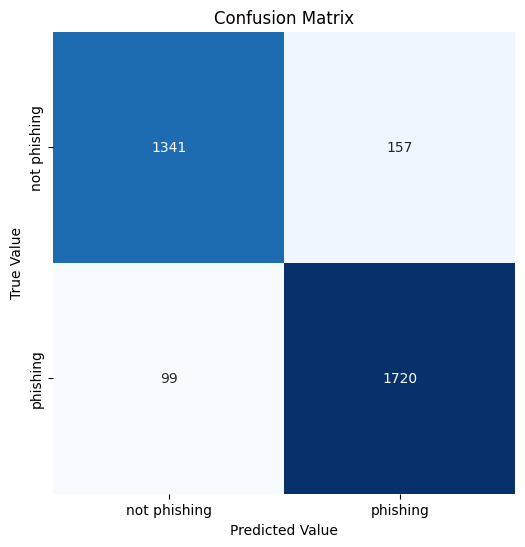

In [ ]:
import seaborn as sns

# TO DO: Calculate confusion matrix (2 marks) : conf_mat

# Below code prints confusion matrix using a heatmap
# Calculate the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)

# Print and visualize the confusion matrix using a heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=['not phishing', 'phishing'],
            yticklabels=['not phishing', 'phishing'],
            square=True, cbar=False)
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# TO DO: Print classification report (2 marks)
from sklearn.metrics import classification_report

# Print the classification report
class_report = classification_report(y_test, y_pred, target_names=['not phishing', 'phishing'])
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

not phishing       0.93      0.90      0.91      1498
    phishing       0.92      0.95      0.93      1819

    accuracy                           0.92      3317
   macro avg       0.92      0.92      0.92      3317
weighted avg       0.92      0.92      0.92      3317



### Questions (11 marks)
1. Is the dataset imbalanced? Does it affect model performance? (1 mark)
2. Does the model overfit or underfit for each of the 3 cases? (3 marks)
3. How do the training and testing accuracy change depending on the amount of data used? Explain with values. (1 mark)
4. In this case, what do a false positive and a false negative represent? Which one is worse? (2 marks)
5. Based on your answer to question 4, would you want to maximize precision or recall? How would you do this? (2 marks)
6. Based on the Log Loss for each of the 3 cases, what can you say about the model in each instance? What is potentially causing these differences? (2 mark)


ANSWER HERE

---
---